In [1]:
!pip install -q pandas numpy seaborn matplotlib mlxtend pyfim kagglehub wordcloud squarify

# Mineria de patrones - Online Retail

Frequent itemsets, reglas de asociacion y patrones emergentes sobre el dataset limpio. Incluye opcion de preprocesamiento en GPU (cudf) y conversion a pandas para FP-Growth.


## Objetivos
- Preparar transacciones con un unico espacio de items (encoder unico)
- Obtener itemsets frecuentes y reglas (soporte, confianza, lift)
- Comparar particiones temporales (H1 vs H2 2011) con growth rate
- Exportar resultados y graficas para observabilidad


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from mlxtend.frequent_patterns import fpgrowth, association_rules, fpmax
from mlxtend.preprocessing import TransactionEncoder
from wordcloud import WordCloud
import squarify

# GPU opcional
try:
    import cudf
    USE_GPU_DEFAULT = True
except ImportError:
    cudf = None
    USE_GPU_DEFAULT = False

sns.set_theme(style="whitegrid")
pd.options.display.float_format = "{:,.4f}".format

## Configuracion


In [3]:
DATA_DIR = Path("data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_online_retail.csv"
RESULTS_DIR = DATA_DIR / "processed"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Parametros
MIN_SUPPORT = 0.01
MAX_LEN = None  # ejemplo: 3 para limitar
MIN_CONFIDENCE = 0.3
SEED = 42
np.random.seed(SEED)
USE_GPU = USE_GPU_DEFAULT  # cambia a False si quieres forzar CPU
print(f"USE_GPU={USE_GPU} (cudf {'disponible' if cudf else 'no disponible'})")


USE_GPU=False (cudf no disponible)


## Carga del dataset procesado


In [4]:
if not PROCESSED_PATH.exists():
    raise FileNotFoundError("Ejecuta primero eda.ipynb para generar cleaned_online_retail.csv")

df_pd = pd.read_csv(PROCESSED_PATH)
df_pd['InvoiceDate'] = pd.to_datetime(df_pd['InvoiceDate'])

df = cudf.from_pandas(df_pd) if (USE_GPU and cudf is not None) else df_pd
print(f"Filas: {len(df_pd):,} | Items unicos: {df_pd['Description'].nunique()} | Facturas: {df_pd['InvoiceNo'].nunique()}")
print(df_pd.head())
print(f"DataFrame en {'GPU' if USE_GPU and cudf else 'CPU'}")


Filas: 494,588 | Items unicos: 2190 | Facturas: 19748
   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER    6.0000   
1     536365     71053                  WHITE METAL LANTERN    6.0000   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER    8.0000   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE    6.0000   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.    6.0000   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00     2.5500 17,850.0000  United Kingdom  
1 2010-12-01 08:26:00     3.3900 17,850.0000  United Kingdom  
2 2010-12-01 08:26:00     2.7500 17,850.0000  United Kingdom  
3 2010-12-01 08:26:00     3.3900 17,850.0000  United Kingdom  
4 2010-12-01 08:26:00     3.3900 17,850.0000  United Kingdom  
DataFrame en CPU


## EDA rapido de tickets e items

In [ ]:

# Distribucion de tamano de ticket e items unicos
invoice_size = df_pd.groupby('InvoiceNo')['Description'].agg(items_totales='count', items_unicos=lambda x: x.nunique())
print(invoice_size.describe().round(2))

plt.figure(figsize=(8, 4))
sns.histplot(invoice_size['items_totales'], bins=40, kde=True, color='#0a9396')
plt.title('Distribucion del tamano de ticket (lineas por factura)')
plt.xlabel('Cantidad de lineas')
plt.ylabel('Facturas')
plt.tight_layout()
plt.show()


## Panorama de productos mas vendidos

In [ ]:

# Top productos, wordcloud y treemap
item_counts = df_pd['Description'].value_counts()
print(item_counts.head(10))

plt.figure(figsize=(9, 5))
sns.barplot(x=item_counts.head(15).values, y=item_counts.head(15).index, palette='viridis')
plt.title('Top 15 productos por frecuencia')
plt.xlabel('Numero de lineas vendidas')
plt.ylabel('Producto')
plt.tight_layout()
plt.show()

wordcloud = WordCloud(width=1000, height=400, background_color='white')
wordcloud = wordcloud.generate_from_frequencies(item_counts.to_dict())
plt.figure(figsize=(11, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud de productos')
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 6))
top_n = item_counts.head(20)
squarify.plot(sizes=top_n.values, label=top_n.index, color=sns.color_palette('Spectral', len(top_n)), alpha=0.85)
plt.axis('off')
plt.title('Treemap: Top 20 productos por frecuencia')
plt.show()


## Particiones temporales
Se separa 2011 en dos mitades para observar cambios estacionales.


In [5]:
cutoff = pd.Timestamp('2011-06-01')
part1 = df[df['InvoiceDate'] < cutoff]
part2 = df[df['InvoiceDate'] >= cutoff]

print(f"H1: {len(part1):,} filas, {part1['InvoiceNo'].nunique()} facturas")
print(f"H2: {len(part2):,} filas, {part2['InvoiceNo'].nunique()} facturas")


H1: 188,150 filas, 8024 facturas
H2: 306,438 filas, 11724 facturas


## Preparacion de transacciones (encoder unico)
Se ajusta `TransactionEncoder` con todas las transacciones para garantizar el mismo espacio de items en cada particion. Se usa pandas para el encoding, pero los filtros previos pueden correr en GPU.


In [6]:
def to_pandas(df_like):
    return df_like.to_pandas() if hasattr(df_like, 'to_pandas') else df_like


def build_transactions(df_part_pd):
    return df_part_pd.groupby('InvoiceNo')['Description'].apply(list).tolist()

# Convertimos a pandas para TransactionEncoder
part1_pd = to_pandas(part1)
part2_pd = to_pandas(part2)
df_all_pd = to_pandas(df)

transactions_all = build_transactions(df_all_pd)
transactions1 = build_transactions(part1_pd)
transactions2 = build_transactions(part2_pd)

te = TransactionEncoder()
te_ary_all = te.fit(transactions_all).transform(transactions_all)
onehot_all = pd.DataFrame(te_ary_all, columns=te.columns_)

# Reusar las mismas columnas para las particiones
te_ary_1 = te.transform(transactions1)
onehot_1 = pd.DataFrame(te_ary_1, columns=te.columns_)

te_ary_2 = te.transform(transactions2)
onehot_2 = pd.DataFrame(te_ary_2, columns=te.columns_)

print(f"Items en espacio comun: {onehot_all.shape[1]}")
print(f"Transacciones totales: {len(transactions_all):,} | H1: {len(transactions1):,} | H2: {len(transactions2):,}")
print(f"Densidad promedio one-hot (ALL): {onehot_all.values.mean():.4f}")


Items en espacio comun: 2190
Transacciones totales: 19,748 | H1: 8,024 | H2: 11,724
Densidad promedio one-hot (ALL): 0.0113


## Funcion auxiliar para itemsets


In [7]:
def run_fpgrowth(df_oh, min_support=MIN_SUPPORT, max_len=MAX_LEN):
    freq = fpgrowth(df_oh, min_support=min_support, use_colnames=True, max_len=max_len)
    freq = freq.sort_values(by='support', ascending=False).reset_index(drop=True)
    return freq


def top_summary(freq, name, n=5):
    print(f"Top {n} itemsets frecuentes - {name}")
    print(freq.head(n))

freq_all = run_fpgrowth(onehot_all)
freq_p1 = run_fpgrowth(onehot_1)
freq_p2 = run_fpgrowth(onehot_2)

top_summary(freq_all, "Dataset completo")
top_summary(freq_p1, "H1")
top_summary(freq_p2, "H2")


Top 5 itemsets frecuentes - Dataset completo
   support                              itemsets
0   0.1142  (WHITE HANGING HEART T-LIGHT HOLDER)
1   0.1058             (JUMBO BAG RED RETROSPOT)
2   0.1007            (REGENCY CAKESTAND 3 TIER)
3   0.0853                       (PARTY BUNTING)
4   0.0792             (LUNCH BAG RED RETROSPOT)
Top 5 itemsets frecuentes - H1
   support                              itemsets
0   0.1412  (WHITE HANGING HEART T-LIGHT HOLDER)
1   0.1243            (REGENCY CAKESTAND 3 TIER)
2   0.1047             (JUMBO BAG RED RETROSPOT)
3   0.0972                       (PARTY BUNTING)
4   0.0818             (LUNCH BAG RED RETROSPOT)
Top 5 itemsets frecuentes - H2
   support                              itemsets
0   0.1065             (JUMBO BAG RED RETROSPOT)
1   0.0958  (WHITE HANGING HEART T-LIGHT HOLDER)
2   0.0845            (REGENCY CAKESTAND 3 TIER)
3   0.0828      (PAPER CHAIN KIT 50'S CHRISTMAS)
4   0.0779                      (SPOTTY BUNTING)


## Itemsets frecuentes con diferentes niveles de soporte

In [ ]:

support_grid = [0.01, 0.02, 0.05]
freq_by_sup = {}
for sup in support_grid:
    freq = run_fpgrowth(onehot_all, min_support=sup, max_len=MAX_LEN)
    freq['len'] = freq['itemsets'].apply(len)
    freq_by_sup[sup] = freq
    print(f"minsup={sup:.0%} -> {len(freq)} itemsets frecuentes")

freq_1pct = freq_by_sup[support_grid[0]]

plt.figure(figsize=(6, 4))
plt.scatter(freq_1pct['len'], freq_1pct['support'], alpha=0.4, color='#bb3e03')
plt.xlabel('Tamano del itemset')
plt.ylabel('Soporte')
plt.title('Soporte vs tamano de itemset (minsup=1%)')
plt.tight_layout()
plt.show()


## Reglas de asociacion (dataset completo)


Reglas generadas: 1888
                                      antecedents  \
1700  (HERB MARKER ROSEMARY, HERB MARKER PARSLEY)   
1701                          (HERB MARKER THYME)   
1702                       (HERB MARKER ROSEMARY)   
1699     (HERB MARKER THYME, HERB MARKER PARSLEY)   
1803                       (HERB MARKER ROSEMARY)   

                                      consequents  support  confidence    lift  
1700                          (HERB MARKER THYME)   0.0103      0.9442 78.6742  
1701  (HERB MARKER ROSEMARY, HERB MARKER PARSLEY)   0.0103      0.8565 78.6742  
1702     (HERB MARKER THYME, HERB MARKER PARSLEY)   0.0103      0.8458 78.4203  
1699                       (HERB MARKER ROSEMARY)   0.0103      0.9531 78.4203  
1803       (HERB MARKER THYME, HERB MARKER BASIL)   0.0101      0.8333 78.3651  


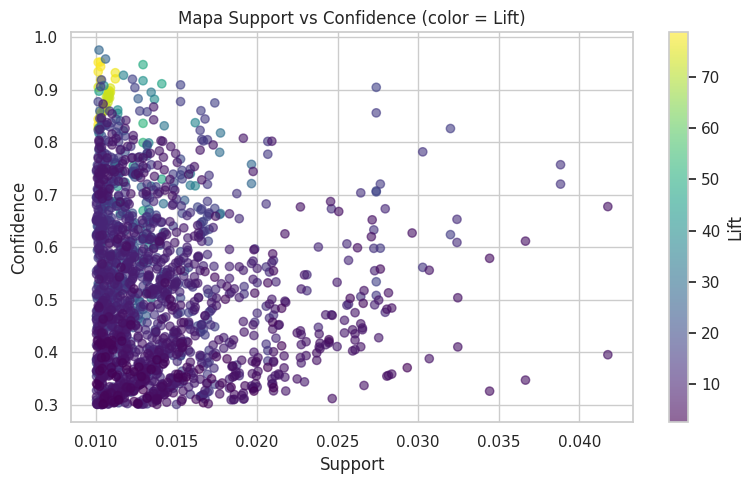

In [8]:
rules = association_rules(freq_all, metric='confidence', min_threshold=MIN_CONFIDENCE)
rules = rules.sort_values(by='lift', ascending=False)
print(f"Reglas generadas: {len(rules)}")
print(rules[['antecedents','consequents','support','confidence','lift']].head())

plt.figure(figsize=(8,5))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Mapa Support vs Confidence (color = Lift)')
plt.tight_layout()
plt.show()


## Reglas de asociacion destacadas

In [ ]:

# Top reglas por lift para lectura rapida
rules_display = rules.copy()
rules_display[['antecedents', 'consequents']] = rules_display[['antecedents', 'consequents']].applymap(lambda x: ', '.join(sorted(x)))
cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']

plt.figure(figsize=(10, 5))
top_rules = rules_display.head(10)
sns.barplot(data=top_rules, x='lift', y='antecedents', hue='consequents', palette='magma')
plt.title('Top 10 reglas por lift')
plt.xlabel('Lift')
plt.ylabel('Antecedente')
plt.legend(title='Consecuente')
plt.tight_layout()
plt.show()


## Patrones emergentes (growth rate H2 vs H1)
Se calcula growth rate comparando soportes de los mismos itemsets entre H1 y H2. Los inf son Jumping Emerging Patterns (JEP).


In [9]:
merged = pd.merge(freq_p1, freq_p2, on='itemsets', how='outer', suffixes=('_1', '_2')).fillna(0)
merged['growth_rate'] = np.where(
    merged['support_1'] == 0,
    np.inf,
    merged['support_2'] / merged['support_1']
)

merged = merged.sort_values(by='growth_rate', ascending=False)

# Segmentos
jep = merged[merged['growth_rate'] == np.inf].sort_values(by='support_2', ascending=False)
inc = merged[(merged['growth_rate'] > 1) & (merged['growth_rate'] != np.inf)].sort_values(by='growth_rate', ascending=False)
stable = merged[(merged['growth_rate'] >= 0.8) & (merged['growth_rate'] <= 1.2)].sort_values(by='support_2', ascending=False)
dec = merged[(merged['growth_rate'] < 0.8) & (merged['support_2'] > 0)].sort_values(by='growth_rate')

print(f"Itemsets comparados: {len(merged)}")
print(f"JEPs: {len(jep)} | Incrementan: {len(inc)} | Estables: {len(stable)} | Decrecen: {len(dec)}")
print("Top 5 JEP (por soporte H2):")
print(jep.head())


Itemsets comparados: 4135
JEPs: 1966 | Incrementan: 482 | Estables: 617 | Decrecen: 300
Top 5 JEP (por soporte H2):
     support_1                            itemsets  support_2  growth_rate
712     0.0000        (SET OF 3 REGENCY CAKE TINS)     0.0745          inf
713     0.0000  (GARDENERS KNEELING PAD KEEP CALM)     0.0723          inf
714     0.0000                    (POPCORN HOLDER)     0.0685          inf
715     0.0000        (HOT WATER BOTTLE KEEP CALM)     0.0667          inf
716     0.0000          (JUMBO BAG 50'S CHRISTMAS)     0.0611          inf


## Visualizaciones de patrones


/tmp/ipykernel_35860/2687554222.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


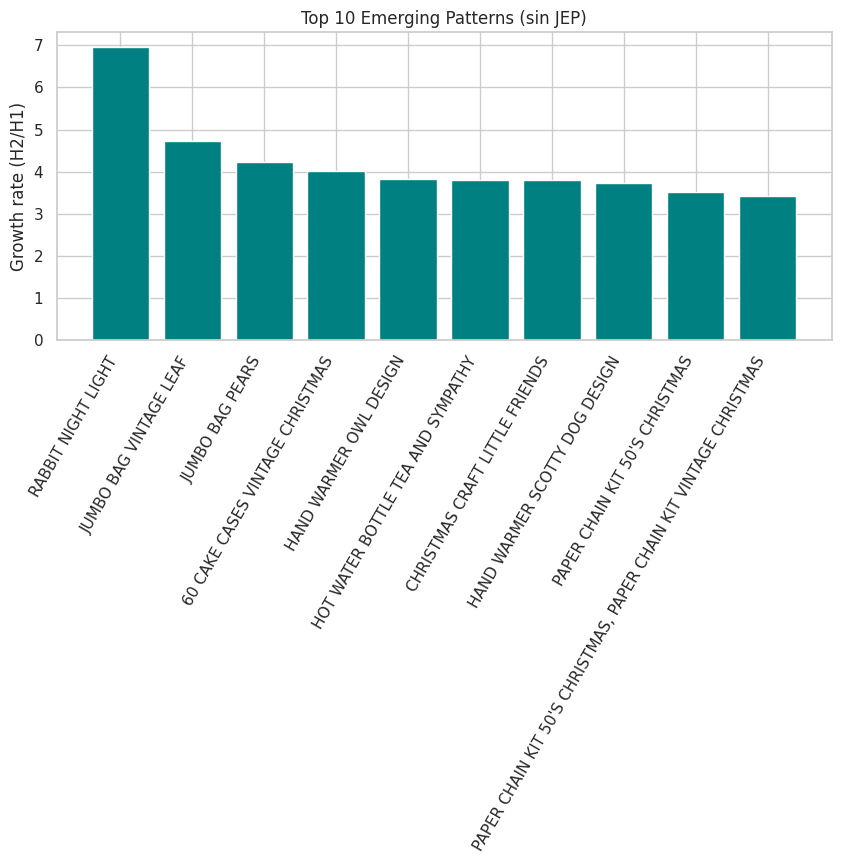

/tmp/ipykernel_35860/2687554222.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_jep['support_2'], y=top_jep['item'], palette='flare')


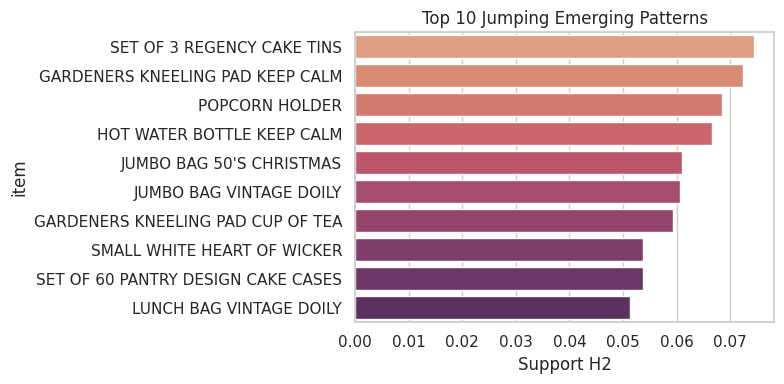

/tmp/ipykernel_35860/2687554222.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_support['support'], y=top_support['item'], palette='crest')


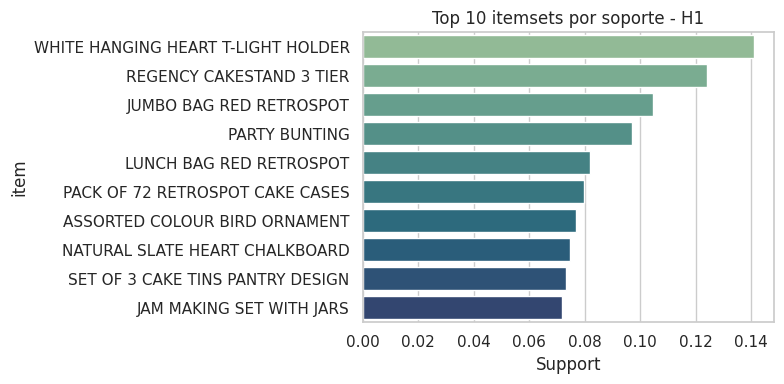

/tmp/ipykernel_35860/2687554222.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_support['support'], y=top_support['item'], palette='crest')


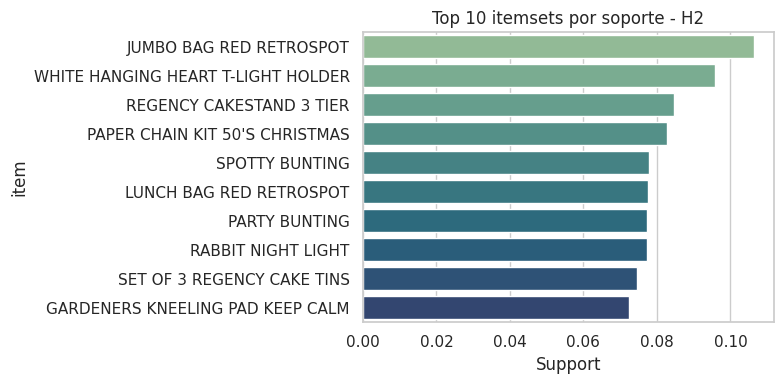

In [10]:
def iset_to_str(s):
    try:
        return ', '.join(sorted(s))
    except Exception:
        return str(s)

# Top growth (sin inf)
top_inc = inc.head(10).copy()
top_inc['item'] = top_inc['itemsets'].apply(iset_to_str)

plt.figure(figsize=(10,4))
plt.bar(top_inc['item'], top_inc['growth_rate'], color='teal')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Growth rate (H2/H1)')
plt.title('Top 10 Emerging Patterns (sin JEP)')
plt.tight_layout()
plt.show()

# JEPs mas soportados
top_jep = jep.head(10).copy()
top_jep['item'] = top_jep['itemsets'].apply(iset_to_str)
plt.figure(figsize=(8,4))
sns.barplot(x=top_jep['support_2'], y=top_jep['item'], palette='flare')
plt.xlabel('Support H2')
plt.title('Top 10 Jumping Emerging Patterns')
plt.tight_layout()
plt.show()

# Top soportes por particion
for name, freq_df in [("H1", freq_p1), ("H2", freq_p2)]:
    top_support = freq_df.head(10).copy()
    top_support['item'] = top_support['itemsets'].apply(iset_to_str)
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_support['support'], y=top_support['item'], palette='crest')
    plt.title(f'Top 10 itemsets por soporte - {name}')
    plt.xlabel('Support')
    plt.tight_layout()
    plt.show()


## Closed y maximal itemsets (minsup=1%)

In [ ]:

# Comparacion closed vs maximal a partir de minsup 1%
itemsets_list = list(freq_1pct['itemsets'])
support_list = list(freq_1pct['support'])
closed = []
maximal = []

for i, (iset, sup) in enumerate(zip(itemsets_list, support_list)):
    is_closed = True
    is_maximal = True
    for j, (jset, jsup) in enumerate(zip(itemsets_list, support_list)):
        if i == j:
            continue
        if iset < jset:
            if sup == jsup:
                is_closed = False
            is_maximal = False
            if not is_closed and not is_maximal:
                break
    if is_closed:
        closed.append((iset, sup))
    if is_maximal:
        maximal.append((iset, sup))

closed_df = pd.DataFrame(closed, columns=['itemset', 'support']).sort_values('support', ascending=False)
maximal_df = pd.DataFrame(maximal, columns=['itemset', 'support']).sort_values('support', ascending=False)
print(f"Closed itemsets (1%): {len(closed_df)}")
print(f"Maximal itemsets (1%): {len(maximal_df)}")
print(closed_df.head())
print(maximal_df.head())


In [ ]:

plt.figure(figsize=(6, 4))
types = pd.DataFrame({
    'tipo': ['Frecuentes (1%)', 'Closed (1%)', 'Maximal (1%)'],
    'count': [len(freq_1pct), len(closed_df), len(maximal_df)]
})
sns.barplot(data=types, x='tipo', y='count', palette='crest')
plt.title('Comparacion de tamanos de colecciones')
plt.ylabel('Numero de itemsets')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.kdeplot(closed_df['support'], label='Closed', shade=True, color='#1d3557')
sns.kdeplot(maximal_df['support'], label='Maximal', shade=True, color='#e63946')
plt.xlabel('Soporte')
plt.title('Distribucion de soportes (minsup=1%)')
plt.legend()
plt.tight_layout()
plt.show()


## Exportar resultados


In [11]:
freq_all.to_csv(RESULTS_DIR / 'frequent_itemsets_all.csv', index=False)
freq_p1.to_csv(RESULTS_DIR / 'frequent_itemsets_h1.csv', index=False)
freq_p2.to_csv(RESULTS_DIR / 'frequent_itemsets_h2.csv', index=False)
rules.to_csv(RESULTS_DIR / 'association_rules_all.csv', index=False)
merged.to_csv(RESULTS_DIR / 'growth_rates_h1_vs_h2.csv', index=False)
print("Archivos guardados en data/processed/")


Archivos guardados en data/processed/
